# Plot Training Data

Import packages

In [1]:
from packaging import version

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import tensorboard as tb
import os
from sklearn.metrics import mean_squared_error


import scienceplots
mpl.rc_file_defaults()
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["legend.edgecolor"] = 'black'
plt.rc('legend', fontsize=10)

def calc_RMSE(data,
              real_values=(0, 0, 5, 0, 0),
              cols=('x', 'y', 'z', 'phi', 'theta'),
              z_settling_time=0,
              ):
    # Compute the RMSE for each column
    for i, col in enumerate(cols):
        pred = data[col]

        if col == 'z':
            pred = data.query('real_time >= @z_settling_time')[col]
            z_sse = pred.mean() - real_values[i]
            print(f'SSE for {col}: {z_sse:.5f}')

        # Get the predicted values and compute the RMSE
        true = real_values[i] * np.ones(len(pred))
        rmse = mean_squared_error(true, pred, squared=False)

        # Print the RMSE
        print(f'RMSE for {col}: {rmse:.5f}')

Load Data from Experiment

In [ ]:
print("Loading Data from Experiment")

experiment_id = "NnW7sm3aTZu3IvjVZ36QSQ"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
all_data1 = experiment.get_scalars()
all_data1 = all_data1[~all_data1["run"].str.contains("position_sigma_7_5")] # V1_2 A.1
print(f"The following runs will be processed: \n"
      f"{all_data1['run'].unique()}")

df = all_data1

print(f"The following runs will be processed: \n"
      f"{df['run'].unique()}")


# Select only the rows where the "tag" column has the values "rollout/ep_len_mean" or "rollout/ep_rew_mean"
df = df[df['tag'].isin(['rollout/ep_len_mean', 'rollout/ep_rew_mean'])]
df = tb.data.experimental.utils.pivot_dataframe(df)

# Rename the columns to "ep_len_mean" and "ep_rew_mean"
df = df.rename(columns={'rollout/ep_len_mean': 'ep_len_mean', 'rollout/ep_rew_mean': 'ep_rew_mean'})

print(f"The following runs will be processed: \n"
      f"{df['run'].unique()}")

In [ ]:
print(os.listdir('logs/ModelB_V1_1,position_sigma_0_25,attitude_sigma_0_62832,run_1_0'))


In [ ]:

# Create a dictionary to store the max ep_rew_mean values for each run
max_values = {}

runs = all_data1['run'].unique()

# Loop over each run and extract the max ep_rew_mean value
for run in runs:
    # run = run[:-2]
    # Parse the position and attitude sigmas from the run name
    position_sigma = float(run.split('position_sigma_')[1].split(',')[0])
    attitude_sigma = float(run.split('attitude_sigma_')[1].split(',')[0])

    # Load the data from the run
    data = pd.read_csv('logs/' + run + '/events.out.tfevents.*',
                       compression='gzip',
                       engine='python')

    # Extract the max ep_rew_mean value
    max_ep_rew_mean = data[data['metric'] == 'ep_rew_mean']['value'].max()

    # Add the max value to the dictionary
    max_values[(position_sigma, attitude_sigma)] = max_ep_rew_mean

# Create a list of position sigmas and attitude sigmas
position_sigmas = sorted(list(set([p for p, a in max_values.keys()])))
attitude_sigmas = sorted(list(set([a for p, a in max_values.keys()])))

# Create a 2D array to store the max values
max_value_array = np.zeros((len(position_sigmas), len(attitude_sigmas)))

# Fill the array with the max values
for i, position_sigma in enumerate(position_sigmas):
    for j, attitude_sigma in enumerate(attitude_sigmas):
        max_value_array[i, j] = max_values[(position_sigma, attitude_sigma)]

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(max_value_array, cmap='viridis',
               extent=[min(attitude_sigmas), max(attitude_sigmas),
                       min(position_sigmas), max(position_sigmas)],
               aspect='auto')
ax.set_xlabel('Attitude Sigma')
ax.set_ylabel('Position Sigma')
ax.set_title('Max ep_rew_mean vs Position and Attitude Sigmas')
fig.colorbar(im, label='Max ep_rew_mean')
plt.show()


In [2]:
import expt
from tqdm import tqdm

# Create a dictionary to store the max ep_rew_mean values for each run
max_values = {}

runs = expt.get_runs('./logs/*')
run = runs[0].name

for run in tqdm(runs):
    # Parse the position and attitude sigmas from the run name
    position_sigma = float(run.name.split('position_sigma_')[1].split(',')[0].replace('_','.'))
    attitude_sigma = float(run.name.split('attitude_sigma_')[1].split(',')[0].replace('_','.'))

    run = run.df
    # Drop train columns
    train_cols = run.filter(regex='^train/').columns
    run = run.drop(train_cols, axis=1)

    run = run.rename(columns={'rollout/ep_len_mean': 'ep_len_mean', 'rollout/ep_rew_mean': 'ep_rew_mean'})


    max_ep_rew_mean = run["ep_rew_mean"].max()

    print(f"p_sigma={position_sigma}    a_sigma={attitude_sigma}")

    # Add the max value to the dictionary
    max_values[(position_sigma, attitude_sigma)] = max_ep_rew_mean


100%|██████████| 40/40 [00:00<00:00, 955.30it/s]

p_sigma=0.25    a_sigma=0.62832
p_sigma=0.25    a_sigma=1.0472
p_sigma=0.25    a_sigma=1.5708
p_sigma=0.25    a_sigma=3.14159
p_sigma=0.5    a_sigma=0.62832
p_sigma=0.5    a_sigma=1.0472
p_sigma=0.5    a_sigma=1.5708
p_sigma=0.5    a_sigma=3.14159
p_sigma=0.75    a_sigma=0.62832
p_sigma=0.75    a_sigma=1.0472
p_sigma=0.75    a_sigma=1.5708
p_sigma=0.75    a_sigma=3.14159
p_sigma=1.0    a_sigma=0.62832
p_sigma=1.0    a_sigma=1.0472
p_sigma=1.0    a_sigma=1.5708
p_sigma=1.0    a_sigma=3.14159
p_sigma=10.0    a_sigma=0.62832
p_sigma=10.0    a_sigma=1.0472
p_sigma=10.0    a_sigma=1.5708
p_sigma=10.0    a_sigma=3.14159
p_sigma=1.5    a_sigma=0.62832
p_sigma=1.5    a_sigma=1.0472
p_sigma=1.5    a_sigma=1.5708
p_sigma=1.5    a_sigma=3.14159
p_sigma=2.0    a_sigma=0.62832
p_sigma=2.0    a_sigma=1.0472
p_sigma=2.0    a_sigma=1.5708
p_sigma=2.0    a_sigma=3.14159
p_sigma=3.0    a_sigma=0.62832
p_sigma=3.0    a_sigma=1.0472
p_sigma=3.0    a_sigma=1.5708
p_sigma=3.0    a_sigma=3.14159
p_sigma=5.0 

In [ ]:

plt.style.use(['science', 'high-vis'])

# Create a list of position sigmas and attitude sigmas
position_sigmas = sorted(list(set([p for p, a in max_values.keys()])))
attitude_sigmas = sorted(list(set([a for p, a in max_values.keys()])))

# Create a 2D array to store the max values
max_value_array = np.zeros((len(position_sigmas), len(attitude_sigmas)))

# Fill the array with the max values
for i, position_sigma in enumerate(position_sigmas):
    for j, attitude_sigma in enumerate(attitude_sigmas):
        max_value_array[i, j] = max_values[(position_sigma, attitude_sigma)]

cmap = 'PuBu'

# Plot the heatmap
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(max_value_array, cmap=cmap,
               extent=[0.5, max(attitude_sigmas),
                       min(position_sigmas), max(position_sigmas)],
               aspect='auto')
ax.set_xlabel('Attitude Sigma')
ax.set_ylabel('Position Sigma')
ax.set_title(f'Max ep_rew_mean vs Position and Attitude Sigmas - {cmap}')
fig.colorbar(im, label='Max ep_rew_mean')

# plt.savefig(f'images/cmaps/sigmaOptimisationHeatMap-{cmap}.png')

plt.show()

/var/folders/w7/pwzrv2qn79vf17jf5gw6kv1m0000gn/T/ipykernel_29950/498548730.py:49: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


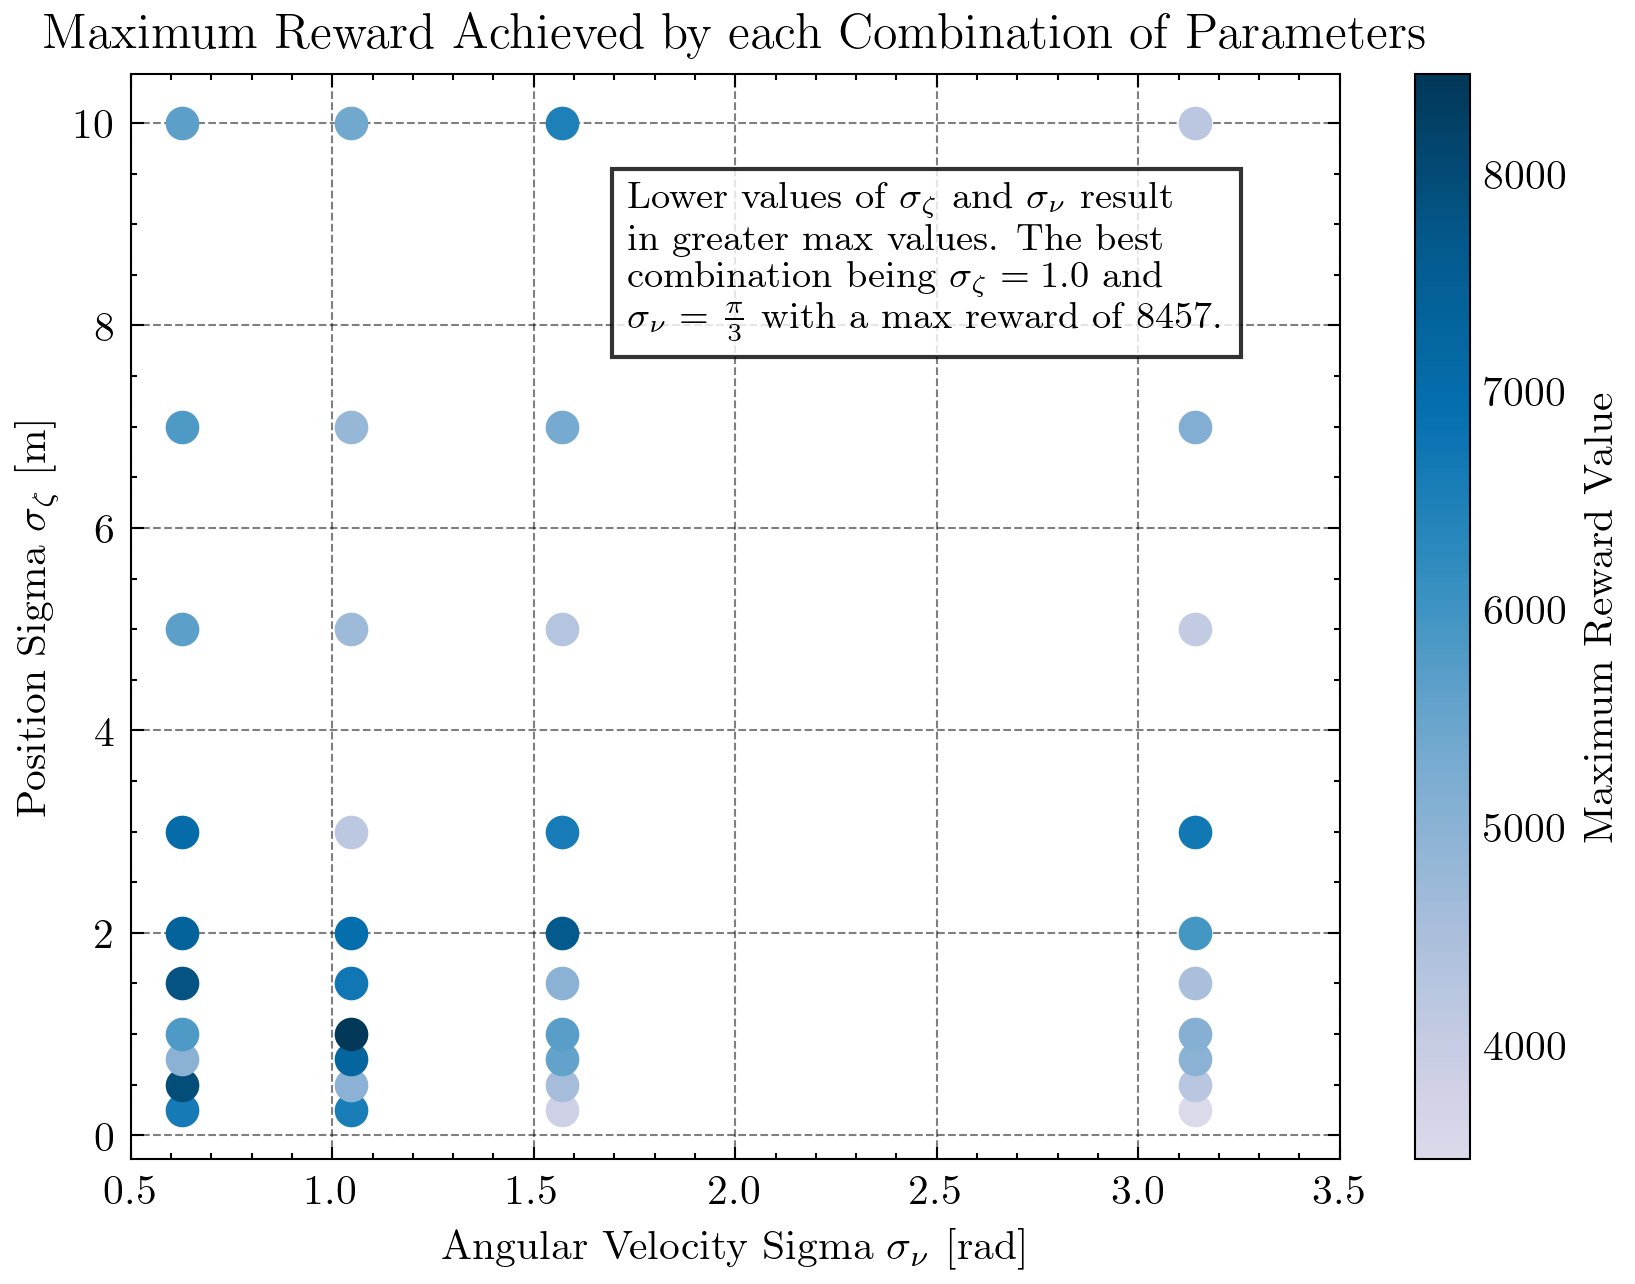

In [7]:
from matplotlib.colors import ListedColormap

plt.style.use(['science', 'grid', 'high-vis'])

# Create a list of position sigmas and attitude sigmas
position_sigmas = sorted(list(set([p for p, a in max_values.keys()])))
attitude_sigmas = sorted(list(set([a for p, a in max_values.keys()])))

# Create a 2D array to store the max values
max_value_array = np.zeros((len(position_sigmas), len(attitude_sigmas)))

# Fill the array with the max values
for i, position_sigma in enumerate(position_sigmas):
    for j, attitude_sigma in enumerate(attitude_sigmas):
        max_value_array[i, j] = max_values[(position_sigma, attitude_sigma)]

# create a flattened list of max values
max_values_list = [max_values[(p, a)] for p in position_sigmas for a in attitude_sigmas]

# get the minimum and maximum values in the max values list
vmin = min(max_values_list)
vmax = max(max_values_list)

# create a colormap
cmap = plt.cm.get_cmap('PuBu')
colors = cmap(np.linspace(0.2, 1, cmap.N))
cmap = ListedColormap(colors)

# create a figure and axis object
fig, ax = plt.subplots(figsize=(6.5, 4.7))

# loop through each position and attitude sigma
for i, p in enumerate(position_sigmas):
    for j, a in enumerate(attitude_sigmas):
        # get the max value at this position and attitude sigma
        max_val = max_values[(p, a)]
        # plot a point at this position with color corresponding to the max value
        ax.scatter(a, p, c=max_val, cmap=cmap, vmin=vmin, vmax=vmax, s=50)

# set axis labels and title
ax.set_xlabel('Angular Velocity Sigma $\sigma_{\\nu}$ [rad]')
ax.set_ylabel('Position Sigma $\sigma_{\zeta}$  [m]')
ax.set_title('Maximum Reward Achieved by each Combination of Parameters')
ax.set_xlim([0.5, 3.5])

# add a colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.ax.set_ylabel('Maximum Reward Value')


# Create the text box
text = "Lower values of $\sigma_{\zeta}$ and $\sigma_{\\nu}$ result\n" \
       "in greater max values. The best\n" \
       "combination being $\sigma_{\zeta}=1.0$ and\n" \
       "$\sigma_{\\nu}=\\frac{\pi}{3}$ with a max reward of $8457$."
bbox = dict(facecolor='white', edgecolor='black', alpha=0.8)
fig.text(0.38, 0.7, text, fontsize=9, bbox=bbox, transform=fig.transFigure)


plt.savefig(f'images/sigmaOptimisationScatterPlot-v3.pdf', dpi=300)

plt.show()

In [ ]:
from scipy.interpolate import griddata

# Create a list of position sigmas and attitude sigmas
position_sigmas = sorted(list(set([p for p, a in max_values.keys()])))
attitude_sigmas = sorted(list(set([a for p, a in max_values.keys()])))
# create new meshgrid of position and attitude sigmas
new_position_sigmas = np.linspace(min(position_sigmas), max(position_sigmas), num=50, endpoint=True)
new_attitude_sigmas = np.linspace(min(attitude_sigmas), max(attitude_sigmas), num=50, endpoint=True)
new_position_mesh, new_attitude_mesh = np.meshgrid(new_position_sigmas, new_attitude_sigmas)

# interpolate the max values over the meshgrid
max_values_list = [max_values[(p, a)] for p, a in zip(position_sigmas, attitude_sigmas)]
max_value_mesh = griddata((position_sigmas, attitude_sigmas),
                          max_values_list,
                          (new_position_mesh, new_attitude_mesh),
                          method='cubic')

In [ ]:
(position_sigmas, attitude_sigmas)
#len(max_values_list)



for (p, a), v in max_values.items():
    if p <= 2 and a <= 1.5:
        pass
        #print(p,a,v)
        #print(v)

highest_keys = sorted(max_values, key=max_values.get, reverse=True)[:5]
highest_keys

NEW SINGLE PLOTS

---

Plot Specific Run - 6 Plots

Getting Data
Cleaning Data
Plotting Data


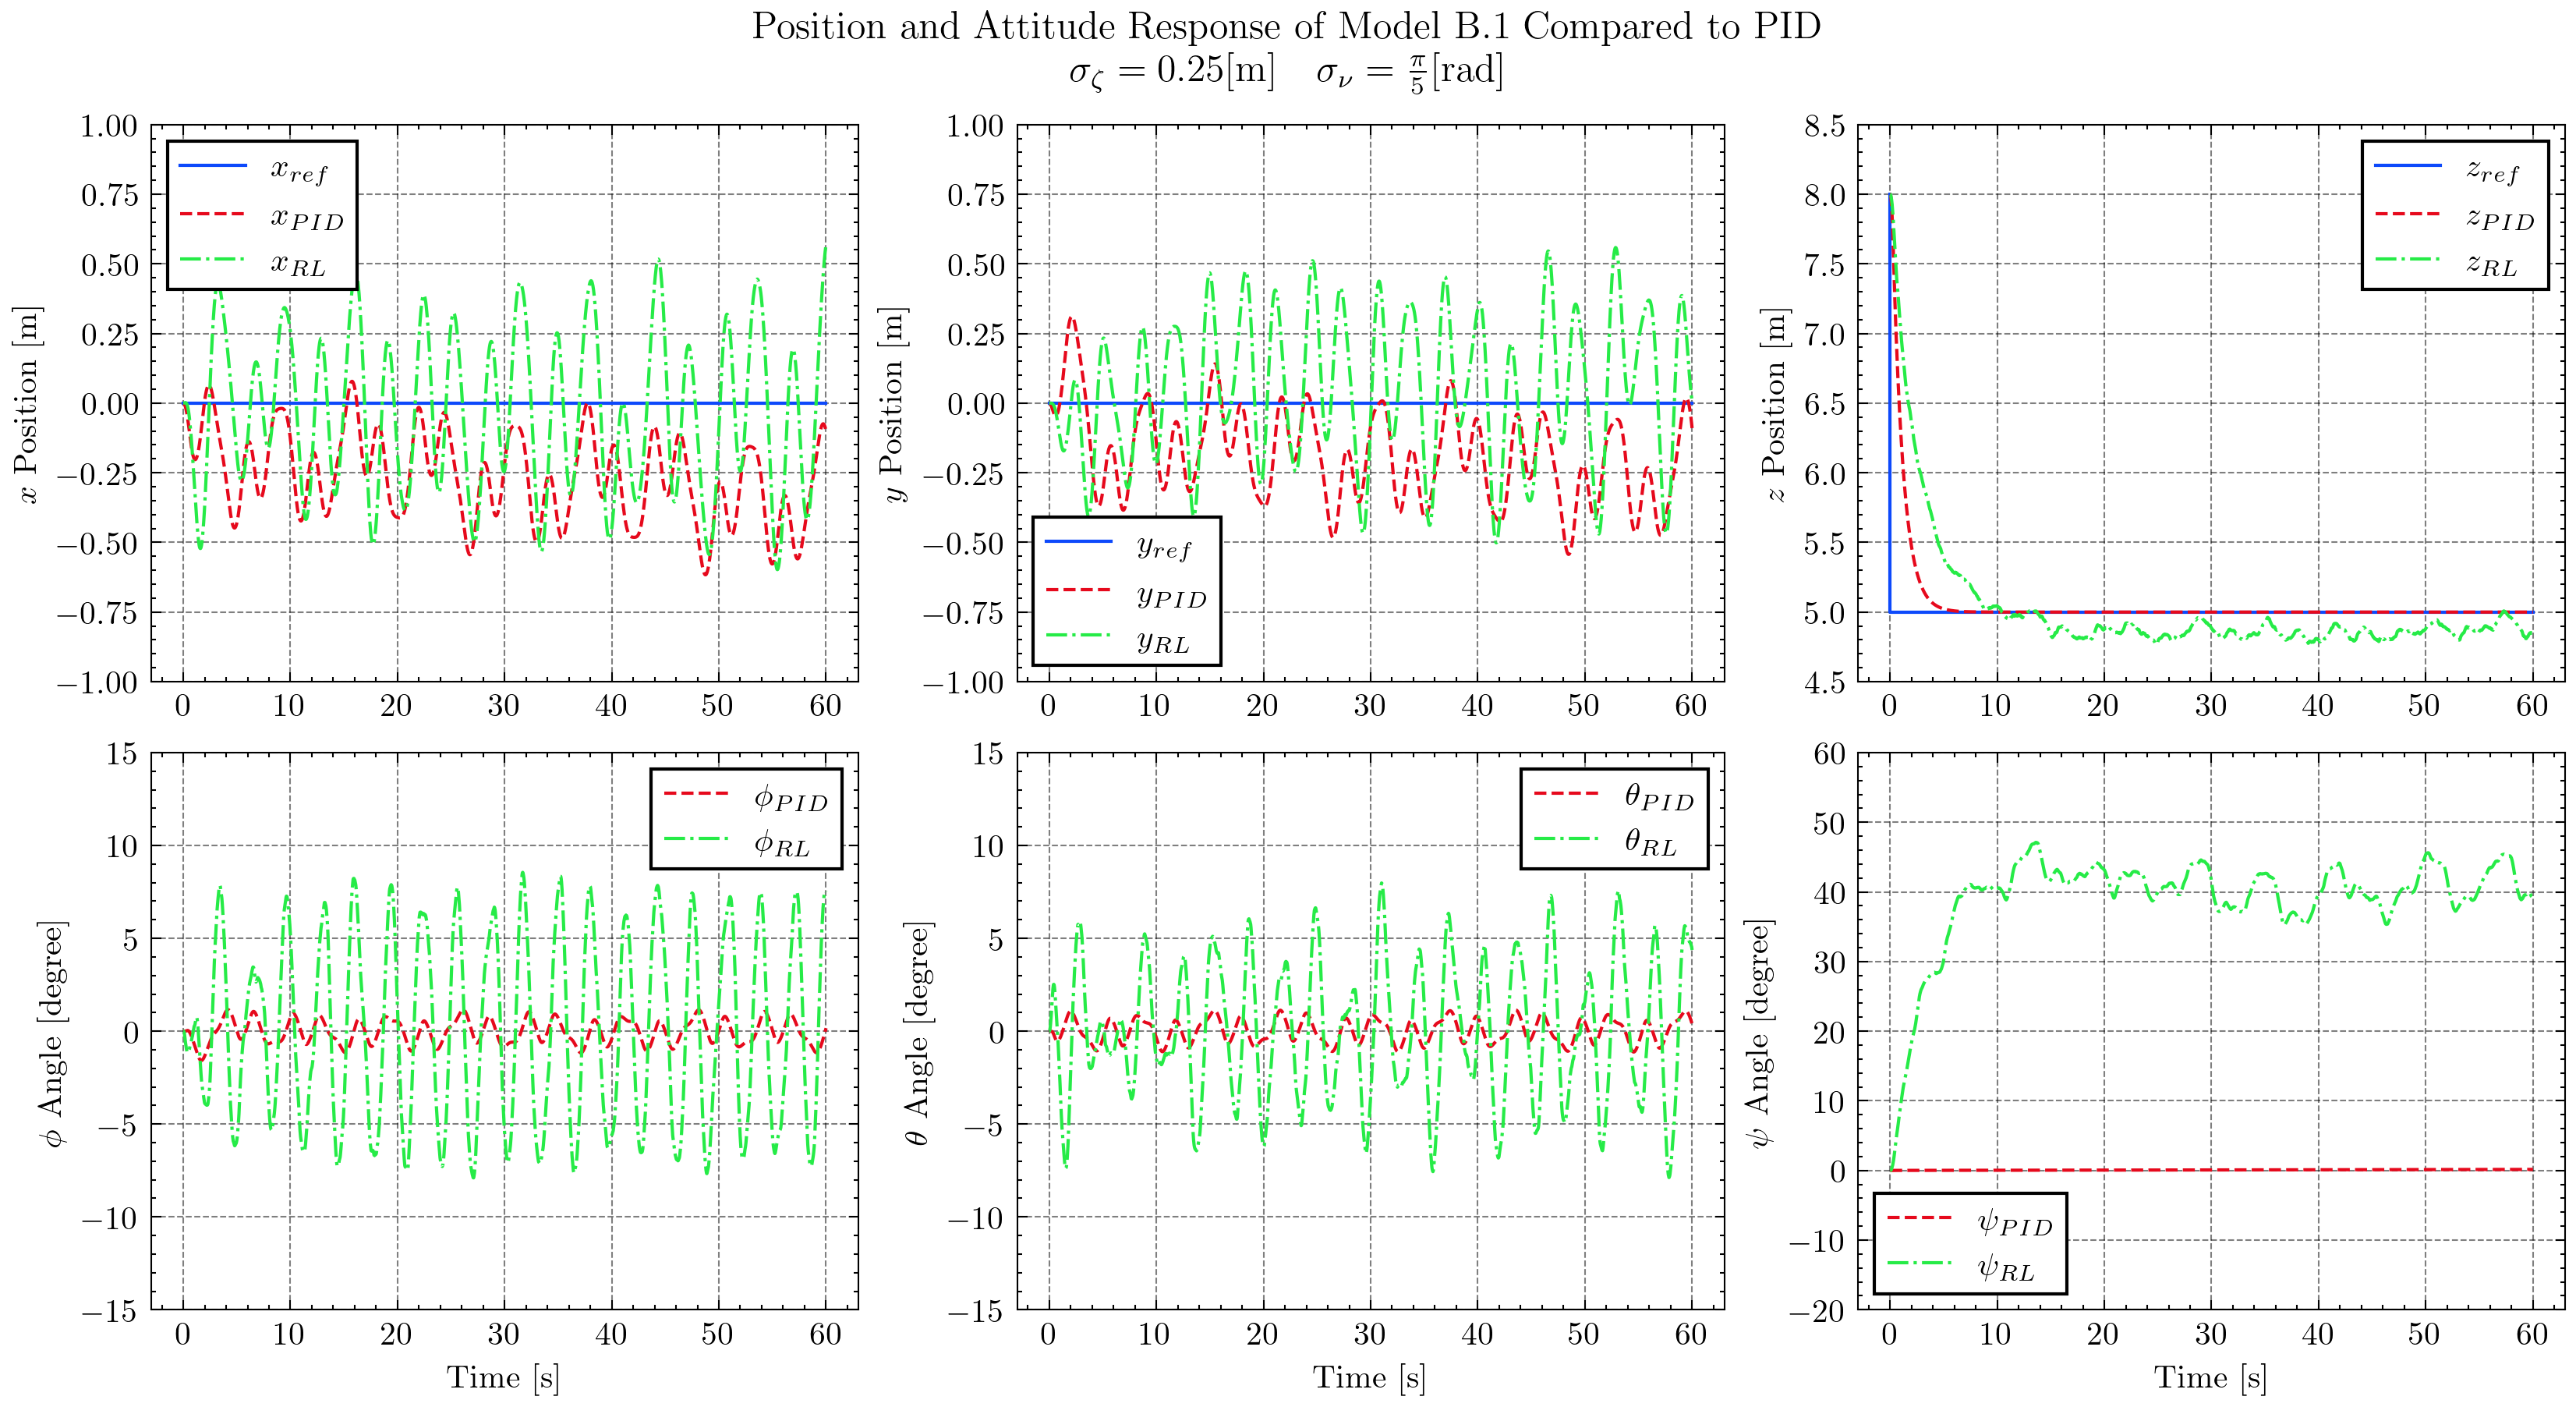

Closing Plots


In [3]:
print("Getting Data")
# RL_data = pd.read_csv("data/RL-ModelB_V1_1,position_sigma_2,attitude_sigma_3_14159,run_1-2800000.csv")
project_name = "RL-ModelB_V1_1,position_sigma_0_25,attitude_sigma_0_62832,run_1-2000000"
RL_data = pd.read_csv(f"data/{project_name}.csv")
# RL_data_modelA1 = pd.read_csv("data/RL-ModelA_V1_2,run_1-2200000.csv")
PID_data = pd.read_csv("data/PID-ModelB_V1_1.csv")

# Data cleaning
print("Cleaning Data")

# Multiply z to be positive upwards
RL_data.loc[:, "z"] *= -1
#RL_data_modelA1.loc[:, "z"] *= -1
PID_data.loc[:, "z"] *= -1

# Convert angles to degrees
RL_data.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi
#RL_data_modelA1.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi
PID_data.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi

symbols = [
    "x",
    "y",
    "z",
    "\phi",
    "\\theta",
    "\psi",
]

ylims = [
    [-1, 1],
    [-1, 1],
    [4.5, 8.5],
    [-15, 15],
    [-15, 15],
    [-20, 60],
]
ylabels = [
    f"${symbols[0]}$ Position [m]",
    f"${symbols[1]}$ Position [m]",
    f"${symbols[2]}$ Position [m]",
    f"${symbols[3]}$ Angle [degree]",
    f"${symbols[4]}$ Angle [degree]",
    f"${symbols[5]}$ Angle [degree]",
]

reference_signals = [
    [[0, 60], [0, 0]],
    [[0, 60], [0, 0]],
    [[0, 0, 60], [8, 5, 5]],
    [],
    [],
    [],
]

plt.style.use(['science', 'grid', 'high-vis'])

rows = 2
cols = 3

fig, ax = plt.subplots(rows, cols, figsize=(11, 6), sharex='row', layout="constrained")

i = 0

print("Plotting Data")
for row in range(rows):
    for col in range(cols):
        if i in [0, 1, 2]:
            ax[row, col].plot(reference_signals[i][0], reference_signals[i][1],
                              label="$" + symbols[i] + "_{ref}$")
        else:
            next(ax[row, col]._get_lines.prop_cycler)


        # l2 = ax[row, col].plot(RL_data_modelA1.iloc[:, 1], RL_data_modelA1.iloc[:, i + 2],
        #                   label="$" + symbols[i] + "_{RL,A.1}$")
        ax[row, col].plot(PID_data.iloc[:, 1], PID_data.iloc[:, i + 2],
                          label="$" + symbols[i] + "_{PID}$")
        l1 = ax[row, col].plot(RL_data.iloc[:, 1], RL_data.iloc[:, i + 2],
                          label="$" + symbols[i] + "_{RL}$")



        # final_point = RL_data.iloc[-1, [1, i + 2]]
        # ax[row, col].plot(final_point[0], final_point[1], 'x', color=l1[0].get_color())

        # final_point = RL_data_modelA1.iloc[-1, [1, i + 2]]
        # ax[row, col].plot(final_point[0], final_point[1], 'x', color=l2[0].get_color())

        ax[row, col].set_xlabel("Time [s]", fontsize=10) if row == 1 else None
        ax[row, col].set_ylabel(ylabels[i], fontsize=10)
        ax[row, col].set_ylim(ylims[i])
        ax[row, col].tick_params(axis='both', which='major', labelsize=10)
        ax[row, col].legend(fontsize=10, fancybox=False, edgecolor='black')

        i += 1

# Create the text box
text = "Model A.1 failed at 5.20 seconds.\nModel A.2 failed at 3.68 seconds."
bbox = dict(facecolor='white', edgecolor='black', alpha=0.8)
# fig.text(0.85, 0.7, text, fontsize=10, bbox=bbox, transform=fig.transFigure)


plt.suptitle("Position and Attitude Response of Model B.1 Compared to PID\n"
             "$\sigma_{\zeta}=0.25[\\text{m}] \quad \sigma_{\\nu}=\\frac{\pi}{5} [\\text{rad}]$")

plt.savefig(f'images/{project_name}-v2.pdf', dpi=300)
plt.show()

print("Closing Plots")
plt.close(fig)


Getting Data
Cleaning Data
Plotting Data


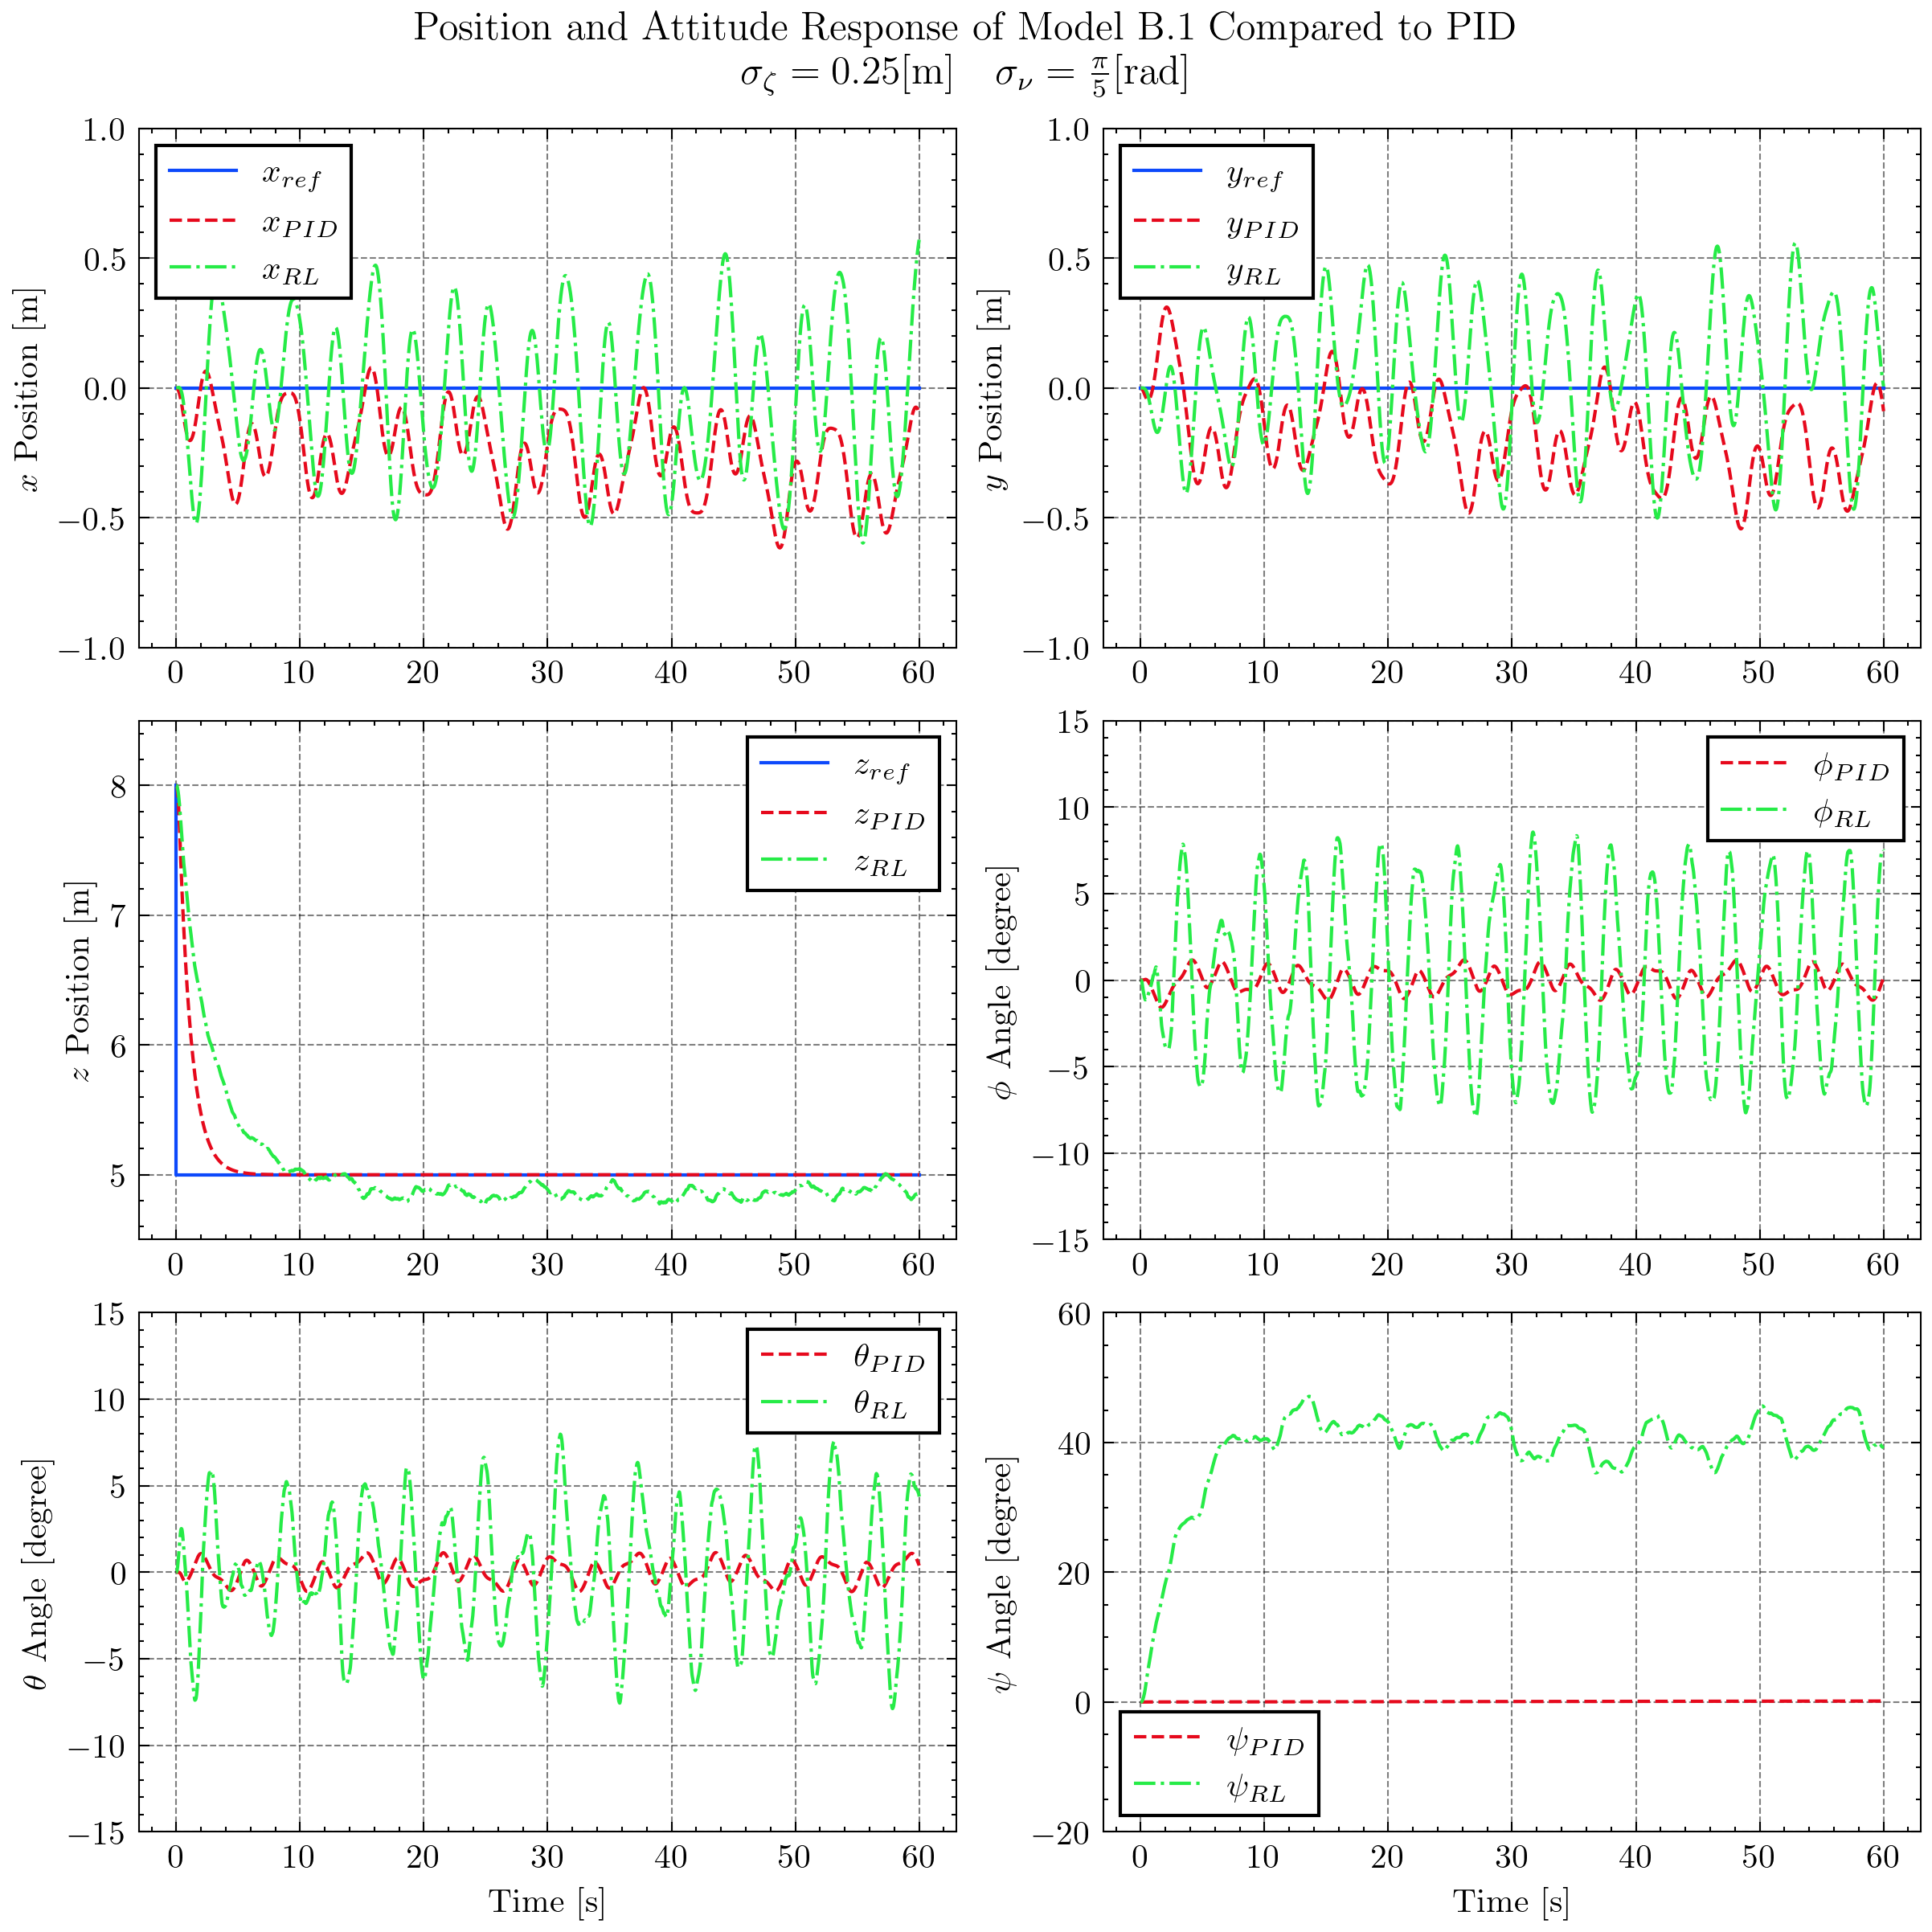

Closing Plots


In [3]:
print("Getting Data")
# RL_data = pd.read_csv("data/RL-ModelB_V1_1,position_sigma_2,attitude_sigma_3_14159,run_1-2800000.csv")
project_name = "RL-ModelB_V1_1,position_sigma_0_25,attitude_sigma_0_62832,run_1-2000000"
RL_data = pd.read_csv(f"data/{project_name}.csv")
# RL_data_modelA1 = pd.read_csv("data/RL-ModelA_V1_2,run_1-2200000.csv")
PID_data = pd.read_csv("data/PID-ModelB_V1_1.csv")

# Data cleaning
print("Cleaning Data")

# Multiply z to be positive upwards
RL_data.loc[:, "z"] *= -1
#RL_data_modelA1.loc[:, "z"] *= -1
PID_data.loc[:, "z"] *= -1

# Convert angles to degrees
RL_data.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi
#RL_data_modelA1.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi
PID_data.loc[:, ["phi", "theta", "psi"]] *= 180 / np.pi

symbols = [
    "x",
    "y",
    "z",
    "\phi",
    "\\theta",
    "\psi",
]

ylims = [
    [-1, 1],
    [-1, 1],
    [4.5, 8.5],
    [-15, 15],
    [-15, 15],
    [-20, 60],
]
ylabels = [
    f"${symbols[0]}$ Position [m]",
    f"${symbols[1]}$ Position [m]",
    f"${symbols[2]}$ Position [m]",
    f"${symbols[3]}$ Angle [degree]",
    f"${symbols[4]}$ Angle [degree]",
    f"${symbols[5]}$ Angle [degree]",
]

reference_signals = [
    [[0, 60], [0, 0]],
    [[0, 60], [0, 0]],
    [[0, 0, 60], [8, 5, 5]],
    [],
    [],
    [],
]

plt.style.use(['science', 'grid', 'high-vis'])

rows = 3
cols = 2

fig, ax = plt.subplots(rows, cols, figsize=(8, 8), sharex='row', layout="constrained")

i = 0

print("Plotting Data")
for row in range(rows):
    for col in range(cols):
        if i in [0, 1, 2]:
            ax[row, col].plot(reference_signals[i][0], reference_signals[i][1],
                              label="$" + symbols[i] + "_{ref}$")
        else:
            next(ax[row, col]._get_lines.prop_cycler)


        # l2 = ax[row, col].plot(RL_data_modelA1.iloc[:, 1], RL_data_modelA1.iloc[:, i + 2],
        #                   label="$" + symbols[i] + "_{RL,A.1}$")
        ax[row, col].plot(PID_data.iloc[:, 1], PID_data.iloc[:, i + 2],
                          label="$" + symbols[i] + "_{PID}$")
        l1 = ax[row, col].plot(RL_data.iloc[:, 1], RL_data.iloc[:, i + 2],
                          label="$" + symbols[i] + "_{RL}$")



        # final_point = RL_data.iloc[-1, [1, i + 2]]
        # ax[row, col].plot(final_point[0], final_point[1], 'x', color=l1[0].get_color())

        # final_point = RL_data_modelA1.iloc[-1, [1, i + 2]]
        # ax[row, col].plot(final_point[0], final_point[1], 'x', color=l2[0].get_color())

        ax[row, col].set_xlabel("Time [s]", fontsize=10) if row == 2 else None
        ax[row, col].set_ylabel(ylabels[i], fontsize=10)
        ax[row, col].set_ylim(ylims[i])
        ax[row, col].tick_params(axis='both', which='major', labelsize=10)
        ax[row, col].legend(fontsize=10, fancybox=False, edgecolor='black')

        i += 1

# Create the text box
text = "Model A.1 failed at 5.20 seconds.\nModel A.2 failed at 3.68 seconds."
bbox = dict(facecolor='white', edgecolor='black', alpha=0.8)
# fig.text(0.85, 0.7, text, fontsize=10, bbox=bbox, transform=fig.transFigure)


plt.suptitle("Position and Attitude Response of Model B.1 Compared to PID\n"
             "$\sigma_{\zeta}=0.25[\\text{m}] \quad \sigma_{\\nu}=\\frac{\pi}{5} [\\text{rad}]$")

plt.savefig(f'images/{project_name}-v3.pdf', dpi=300)
plt.show()

print("Closing Plots")
plt.close(fig)


In [42]:
RL_data.describe()

predicted = RL_data['x']

rmse = mean_squared_error(np.zeros(len(predicted)), predicted, squared = False)


# Define the real values
real_values = [0, 0, 5, 0, 0]

# Select the columns to compute RMSE for
cols = ['x', 'y', 'z', 'phi', 'theta']

print("RL")
calc_RMSE(RL_data, z_settling_time=6.63)

print("PID")
calc_RMSE(PID_data, z_settling_time=3.13)

RL
RMSE for x: 0.28235
RMSE for y: 0.26249
SSE for z: -0.11372
RMSE for z: 0.14046
RMSE for phi: 4.95066
RMSE for theta: 3.65560
PID
RMSE for x: 0.30494
RMSE for y: 0.24848
SSE for z: 0.00264
RMSE for z: 0.01412
RMSE for phi: 0.63150
RMSE for theta: 0.61301


\begin{table}[H]
\normalsize
    \centering
    \begin{tabular}{c c c c | c c}
        \hline
        \rowcolor{light-gray}
        Parameter & Characteristic & Units & Symbol & Model B.1 & PID\\
        \hline
        \multirow{1}{*}{} $x$ Response & Root Mean Squared Error & \SI{}{\metre} & $x_{RMSE}$ & $0.28235$ & $0.30494$ \\
        \hline
        \multirow{1}{*}{} $y$ Response & Root Mean Squared Error & \SI{}{\metre} & $y_{RMSE}$ & $0.26249$ & $0.24848$ \\
        \hline
        \multirow{3}{*}{} $z$ Response & Root Mean Squared Error & \SI{}{\metre} & $z_{RMSE}$ & $0.14046$ & $0.01412$ \\
        & Settling Time & \SI{}{\second} & $T_s$ & $6.63$ & $3.13$ \\
        & Steady State Error & \SI{}{\metre} & $z_{SSE}$ & $-0.11372$ & $0.00264$ \\
        \hline
        \multirow{1}{*}{} $\phi$ Response & Root Mean Squared Error & \SI{}{\radian} & $\phi_{RMSE}$ & $4.95066$ & $0.63150$ \\
        \hline
        \multirow{1}{*}{} $\theta$ Response & Root Mean Squared Error & \SI{}{\radian} & $\theta_{RMSE}$ & $3.65560$ & $0.61301$ \\
        \hline
    \end{tabular}
\caption{Table detailing the response characteristics of both the PID law and Model B.1.}
\label{table:experimentation:modelB.1:responseCharacteristics}
\end{table}


In [ ]:

tdf = PID_data.query("real_time > 10.39 ")
plt.plot(tdf["real_time"], tdf["phi"])
plt.show
tdf.tail(20)

In [ ]:
# RL z freq and amplitude cals

tdf = RL_data.query("real_time > 10.39 ")
plt.plot(tdf["real_time"], tdf["z"])
plt.show
y_final = 4.78 + (4.95-4.78)/2
y_final

In [ ]:
# PID z freq and amplitude cals

tdf = PID_data.query("real_time > 10")
plt.plot(tdf["real_time"], tdf["z"])
plt.show

In [ ]:
tdf = PID_data
plt.plot(tdf["real_time"], tdf["phi"])
plt.show
tdf

In [ ]:
# DATA FOR RL

time_period = 3.41
frequency = 1/time_period
settling_time = 6.63

frequency

# s1 =
#          RiseTime: 5.39505911370009
#     TransientTime: 6.67184064573636
#      SettlingTime: 6.67184064573636
#       SettlingMin: 4.7707586
#       SettlingMax: 5.2981057
#         Overshoot: 7.64138000000001
#        Undershoot: 0
#              Peak: 3.2292414
#          PeakTime: 24.88
# tolerance set to 0.08


In [ ]:
# PID REPOSNSE


# s2 =
#          RiseTime: 2.18694815670258
#     TransientTime: 3.13140883046849
#      SettlingTime: 3.13140883046849
#       SettlingMin: 4.9998674
#       SettlingMax: 5.2975492
#         Overshoot: 0.00441999999998277
#        Undershoot: 0
#              Peak: 3.0001326
#          PeakTime: 28.5
# tolernace set to 0.05